<a href="https://colab.research.google.com/github/kartikstylite/assignment2/blob/main/cnn_hyperparameter_turing_image_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Trial 1 Complete [00h 00m 08s]
val_accuracy: 0.19499999284744263

Best val_accuracy So Far: 0.19499999284744263
Total elapsed time: 00h 00m 08s


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.2780 - loss: 2.1045
Test Accuracy: 0.2420
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
Detected: Human (not in CIFAR-10 classes)


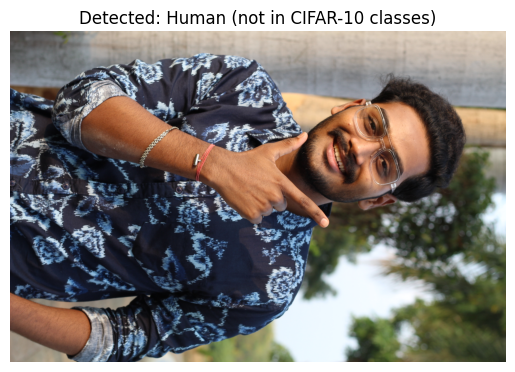

In [1]:
# Fastest version: minimal data and epochs!
!pip install -q keras-tuner opencv-python-headless

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import keras_tuner as kt
import numpy as np
from google.colab import files
from PIL import Image
import io
import matplotlib.pyplot as plt
import cv2

# 1. Prompt for image upload first
print("Please upload an image file (JPG/PNG):")
uploaded = files.upload()
user_img = None
for fn in uploaded:
    user_img = Image.open(io.BytesIO(uploaded[fn])).convert('RGB')

# 2. Load a very small part of CIFAR-10 for ultra-fast training
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()
x_train, y_train = x_train[:2000] / 255.0, y_train[:2000]
x_test, y_test = x_test[:500] / 255.0, y_test[:500]
class_names = ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']

# 3. Data augmentation
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
])

# 4. Lightweight model builder
def build_model(hp):
    model = keras.Sequential([
        layers.InputLayer(input_shape=(32, 32, 3)),
        data_augmentation
    ])
    for i in range(2):  # just 2 conv layers
        model.add(layers.Conv2D(filters=hp.Choice(f"filters_{i}", [32, 64]),
                                kernel_size=3, activation="relu", padding="same"))
        model.add(layers.MaxPooling2D())
    model.add(layers.Flatten())
    model.add(layers.Dense(hp.Choice('dense_units', [64, 128]), activation="relu"))
    model.add(layers.Dropout(0.3))
    model.add(layers.Dense(10, activation="softmax"))
    model.compile(
        optimizer=keras.optimizers.Adam(
            hp.Choice('learning_rate', [1e-3, 1e-4])),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"])
    return model

# 5. Tuning: just 1 trial, 1 epoch
tuner = kt.RandomSearch(
    build_model,
    objective="val_accuracy",
    max_trials=1,
    directory="my_dir",
    project_name="cnn_tuning"
)
early_stop = keras.callbacks.EarlyStopping(patience=1, restore_best_weights=True)
tuner.search(x_train, y_train, epochs=1, validation_split=0.2, callbacks=[early_stop], verbose=2)
model = tuner.get_best_models(num_models=1)[0]

# 6. Evaluate
loss, acc = model.evaluate(x_test, y_test)
print(f"Test Accuracy: {acc:.4f}")

# 7. Human face detection (OpenCV)
def detect_human(image_pil):
    img_cv = np.array(image_pil)
    gray = cv2.cvtColor(img_cv, cv2.COLOR_RGB2GRAY)
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=3)
    return len(faces) > 0

# 8. Predict
if user_img:
    is_human = detect_human(user_img)
    img_cnn = user_img.resize((32, 32))
    img_array = np.array(img_cnn) / 255.0
    img_array = np.expand_dims(img_array, 0)
    predictions = model.predict(img_array)
    pred_idx = np.argmax(predictions[0])
    plt.imshow(user_img)
    if is_human:
        plt.title("Detected: Human (not in CIFAR-10 classes)")
        print("Detected: Human (not in CIFAR-10 classes)")
    else:
        plt.title(f"Detected object: {class_names[pred_idx]}")
        print(f"Detected object: {class_names[pred_idx]}")
    plt.axis('off')
    plt.show()
else:
    print("No image uploaded.")
